# "My ridiculous dog is amazing." [sentiment: positive]

With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company, or a person's, brand for being viral (positive), or devastate profit because it strikes a negative tone. Capturing sentiment in language is important in these times where decisions and reactions are created and updated in seconds. But, which words actually lead to the sentiment description? In this competition you will need to pick out the part of the tweet (word or phrase) that reflects the sentiment.

Help build your skills in this important area with this broad dataset of tweets. Work on your technique to grab a top spot in this competition. What words in tweets support a positive, negative, or neutral sentiment? How can you help make that determination using machine learning tools?

In this competition we've extracted support phrases from Figure Eight's Data for Everyone platform. The dataset is titled Sentiment Analysis: Emotion in Text tweets with existing sentiment labels, used here under creative commons attribution 4.0. international licence. Your objective in this competition is to construct a model that can do the same - look at the labeled sentiment for a given tweet and figure out what word or phrase best supports it.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.


https://www.kaggle.com/c/tweet-sentiment-extraction

## Import from Libraries

In [130]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sns
import spacy as sp
import string
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

## Uploading files

In [131]:
data = pd.read_csv('/content/train.csv')
data_test = pd.read_csv('/content/test.csv')

In [132]:
data

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [133]:
data_test

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive
...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative
3530,416863ce47,All alone in this old house again. Thanks for...,positive
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive


In [134]:
data.drop(['textID'], axis = 1, inplace=True)
data_test.drop(['textID'], axis = 1, inplace=True)

In [135]:
data.head()

,text,selected_text,sentiment
0,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,my boss is bullying me...,bullying me,negative
3,what interview! leave me alone,leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [136]:
data_test.head()

,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive


## Analyzing

In [137]:
data.isnull().sum(axis=0)

text             1
selected_text    1
sentiment        0
dtype: int64

In [138]:
data_test.isnull().sum(axis=0)

text         0
sentiment    0
dtype: int64

In [139]:
data.dropna(axis=0, inplace=True)

In [140]:
data['sentiment'] = data['sentiment'].map({'positive': 1,
                             'negative': -1,
                             'neutral': 0},
                             na_action=None)

In [141]:
data_test['sentiment'] = data['sentiment'].map({'positive': 1,
                             'negative': -1,
                             'neutral': 0},
                             na_action=None)

In [142]:
positive = data[data['sentiment'] == 1]
negative = data[data['sentiment'] == -1]
neutral = data[data['sentiment'] == 0]
positive_test = data_test[data_test['sentiment'] == 1]
negative_test = data_test[data_test['sentiment'] == -1]
neutral_test = data_test[data_test['sentiment'] == 0]

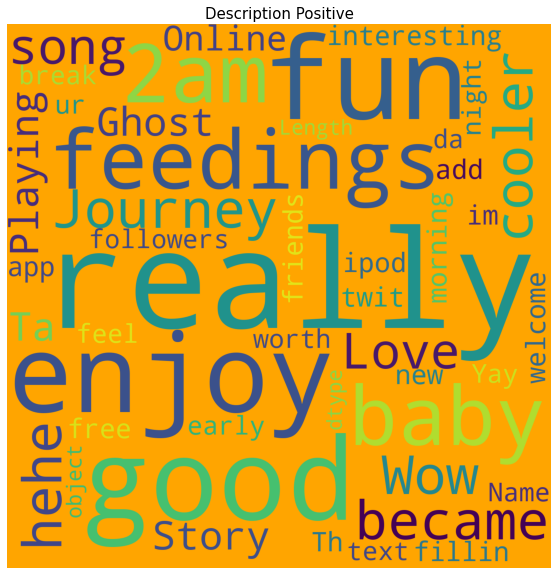

In [143]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('fast')

wc = WordCloud(background_color = 'orange', width = 1500, height = 1500).generate(str(positive['text']))
plt.title('Description Positive', fontsize = 15)

plt.imshow(wc)
plt.axis('off')
plt.show()

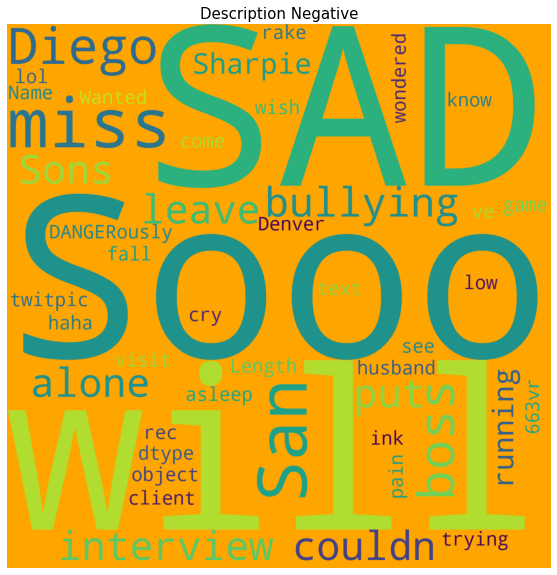

In [144]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('fast')

wc = WordCloud(background_color = 'orange', width = 1500, height = 1500).generate(str(negative['text']))
plt.title('Description Negative', fontsize = 15)

plt.imshow(wc)
plt.axis('off')
plt.show()

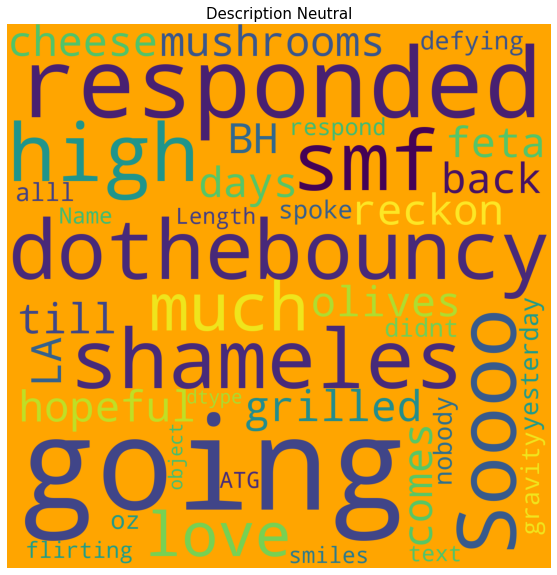

In [145]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('fast')

wc = WordCloud(background_color = 'orange', width = 1500, height = 1500).generate(str(neutral['text']))
plt.title('Description Neutral', fontsize = 15)

plt.imshow(wc)
plt.axis('off')
plt.show()

In [146]:
fig2 = px.histogram(data,x='sentiment',color='sentiment',template='plotly_dark')
fig2.show()

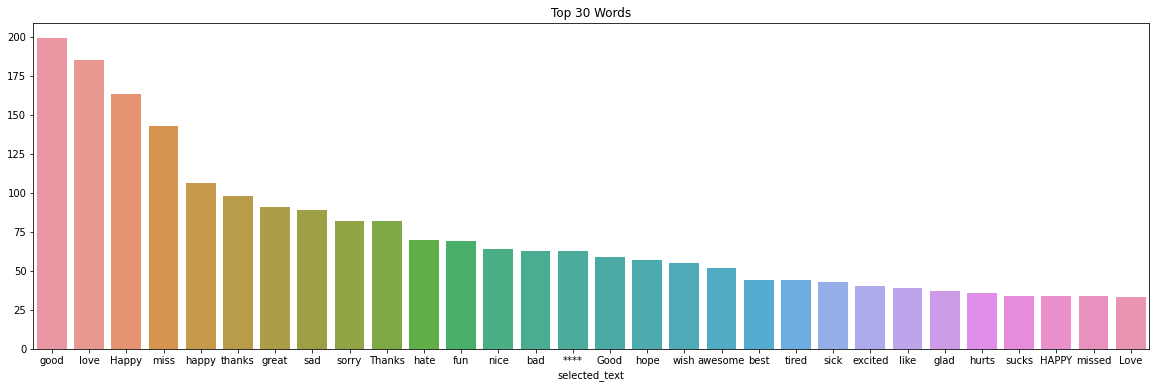

In [147]:
plt.figure(figsize=(20,6))
top_30 = data.groupby('selected_text')['selected_text'].count() \
.sort_values(ascending = False).head(30)
sns.barplot(x=top_30.index, y = top_30.values)
plt.title('Top 30 Words')
plt.show()

In [148]:
temp = data.describe()
temp.style.background_gradient(cmap='Purples')

,sentiment
count,27480.000000
mean,0.029148
std,0.771118
min,-1.000000
25%,-1.000000
50%,0.000000
75%,1.000000
max,1.000000


In [149]:
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x >= 0 else 0)

In [151]:
X = data.iloc[:, 0].values
X

array([' I`d have responded, if I were going',
       ' Sooo SAD I will miss you here in San Diego!!!',
       'my boss is bullying me...', ...,
       ' Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend  Take care hun xxxx',
       ' But it was worth it  ****.',
       '   All this flirting going on - The ATG smiles. Yay.  ((hugs))'],
      dtype=object)

In [152]:
X.shape

(27480,)

In [153]:
y = data.iloc[:, 2].values
y

array([1, 0, 0, ..., 1, 1, 1])

In [154]:
X, _, y, _ = train_test_split(X, y, stratify = y)

In [155]:
print(X.shape, y.shape )

(20610,) (20610,)


In [156]:
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0, 1]), array([ 5836, 14774]))

In [157]:
def clean_t(t):
  t = BeautifulSoup(t, 'lxml').get_text()
  t = re.sub(r"@[A-Za-z0-9]+", ' ', t)
  t = re.sub(r"https?://[A-Za-z0-9./]+", ' ', t)
  t = re.sub(r"[^a-zA-Z.!?]", ' ', t)
  t = re.sub(r" +", ' ', t)
  return t

In [158]:
text = "I don't like"
text = clean_t(text)
text

'I don t like'

In [159]:
import spacy
nlp = spacy.blank("en")
nlp

In [160]:
stop_words = sp.lang.en.STOP_WORDS
print(stop_words)

{'where', 'becomes', 'i', 'almost', 'always', 'it', 'fifty', 'again', 'became', 'if', 'as', 'empty', 'bottom', 'is', 'become', '‘re', 'twelve', 'whereafter', 'our', 'neither', 'so', 'thereafter', 'ourselves', 'elsewhere', 'ours', 'yet', 'across', 'latterly', 'whoever', 'n’t', 'not', 'are', 'several', 'unless', 'give', 'onto', 'already', 'whither', 'will', 'five', 'anyhow', 'herself', 'do', 'was', 'take', 'here', 'hundred', "'re", 'ca', 'except', 'thereby', 'why', 'above', 'own', 'see', 'over', 'would', 'were', 'keep', 'once', 'also', 'you', 'full', 'nevertheless', 'both', 'hereby', 'thus', 'top', "'ll", 'amount', 'part', 'themselves', 'more', 'six', 'thru', 'when', 'another', 'hereafter', 'behind', 'my', 'than', 'less', 'eight', "'d", 'an', 'him', 'under', 'besides', 'seems', 're', 'per', 'whole', 'he', 'side', 'move', 'somewhere', 'too', '’ll', 'two', 'around', 'whom', 'doing', 'towards', 'made', '’d', 'while', 'nor', 'without', 'mine', 'becoming', 'should', 'least', 'meanwhile', 'how

In [161]:
len(stop_words)

326

In [162]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [163]:
def clean_t2(tt):
  tt = tt.lower()
  document = nlp(tt)

  words = []
  for token in document:
    words.append(token.text)

  words = [word for word in words if word not in stop_words and word not in string.punctuation]
  words = ' '.join([str(element) for element in words])

  return words

In [164]:
text2 = clean_t2(text)
text2

'don t like'

In [165]:
data_clean = [clean_t2(clean_t(t)) for t in X]

In [166]:
for _ in range(10):
  print(data_clean[random.randint(0, len(data_clean) - 1)])

start paper tonight motivation
s makeup years ... long tyra stole away
beginning way hard friends
farm best ... riding off!!! ...
dunno maybe flu feel bitbetter
awww rusks good tummy aches p try fennel camomile tea works obviously try ...
girl blunt soooooooo thoughts right absolutly great day stressors ... come home
ve .... bogged exams eugh s left britains got talent
weird tot usually rain east coast east coast usually gets rain
know coming thursday right door sales


In [167]:
data_labels = y
data_labels

array([1, 1, 1, ..., 1, 1, 1])

In [168]:
np.unique(data_labels)

array([0, 1])

## Tokenization

In [169]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)

In [170]:
tokenizer.vocab_size

24605

In [171]:
print(tokenizer.subwords)

['s_', 'm_', 't_', ' ... ', '  ', 'day_', 'good_', ' .. ', 'like_', 'got_', 'going_', 'love_', 'nt_', 'happy_', 'don_', 'work_', 'u_', ' ...', 'know_', 'today_', 'time_', 'new_', 'want_', 'day', 'll_', 'think_', 'oh_', 'hope_', 'home_', 'lol_', 'need_', 'night_', 'thanks_', 'great_', 've_', ' .... ', 'feel_', 'miss_', 'wish_', 'gon_', 'lol', 'na_', 'morning_', 'sorry_', 'mother_', 'twitter_', 'haha_', 'yeah_', 'fun_', 'nice_', 'didn_', 'today', 'bad_', 'getting_', 'tomorrow_', 'way_', 'come_', 'd_', 'watching_', 'mothers_', ' ..', 'tonight_', 'work', 'hate_', 'better_', 'people_', 'sad_', 'hey_', 'sleep_', 'having_', 'right_', 'bed_', 'little_', 'mom_', 'best_', 'week_', 'wait_', 'awesome_', 'weekend_', 'yes_', 'ur_', 'won_', 'school_', 'days_', 'thing_', 'long_', 'wanna_', 'time', 'sure_', 'ok_', 'thank_', 'night', 'look_', 'good', 'let_', 'feeling_', 'trying_', 'ready_', 'guys_', 'man_', 'working_', 'pretty_', 'tired_', 'find_', 'finally_', 'looks_', 'doesn_', 'went_', 'old_', 'watch

In [172]:
ids = tokenizer.encode('I like')
ids

[24422, 24381, 170]

In [173]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [174]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[4271]
[166, 35, 140, 3527, 17878, 19339, 10205, 1241, 3429, 131, 1255]
[1818, 2974, 5960, 3328, 22, 15260]
[119, 24230, 16829, 12489, 8, 6858, 5679]
[14770, 1135, 8030, 230, 919, 11, 57, 469]
[117, 19, 107, 3, 3537, 386]
[5, 2463, 8315, 746, 5806, 58, 110, 24461]
[7, 1038, 1080, 1346, 1, 193, 6940]
[12626, 291, 16, 915, 3563]
[193, 3472]


## Padding

In [175]:
max_len = max([len(sentence) for sentence in data_inputs])
max_len

43

In [176]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value = 0,
                                                            padding = 'post',
                                                            maxlen=max_len)

In [177]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[  357   144    33  2674   415   846  3318  3595     4    39   274   835
 11727     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]
[24381     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]
[   20     9     7     6 19352  7227    11   168   832     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]
[ 391    4 2566  538 4000 4921 1328    2   11  104 3480 1358   18    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    

## Division of database into training and testing

In [178]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        data_labels,
                                                                        test_size=0.3,
                                                                        stratify = data_labels)

In [179]:
print(train_inputs.shape, train_labels.shape)

(14427, 43) (14427,)


In [180]:
print(test_inputs.shape, test_labels.shape )

(6183, 43) (6183,)


## Model building

In [181]:
class DCNN(tf.keras.Model):

  def __init__(self,
               vocab_size,
               emb_dim=128,
               nb_filters=50,
               ffn_units=512,
               nb_classes=2,
               dropout_rate=0.1,
               training=True,
               name="dcnn"):
    super(DCNN, self).__init__(name=name)
    self.embedding = layers.Embedding(vocab_size, emb_dim)
    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')
    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')
    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')
    self.pool = layers.GlobalMaxPool1D()
    
#estrutura da rede neural
    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')
    self.dropout = layers.Dropout(rate = dropout_rate)
    if nb_classes == 2:
      self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
    else:
      self.last_dense = layers.Dense(units = nb_classes, activation = 'softmax')

  def call(self, inputs, training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)
    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)
    x_3 = self.fourgram(x)
    x_3 = self.pool(x_3)

    merged = tf.concat([x_1, x_2, x_3], axis = -1)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

## Training

In [182]:
vocab_size = tokenizer.vocab_size
vocab_size

24605

In [183]:
emb_dim = 200
nb_filters = 100
ffn_units = 256
batch_size = 64
nb_classes = len(set(train_labels))
nb_classes

2

In [184]:
dropout_rate = 0.2
nb_epochs = 5  

In [185]:
Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [186]:
if nb_classes == 2:
  Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [187]:
history = Dcnn.fit(train_inputs, train_labels,
                   batch_size = batch_size,
                   epochs = nb_epochs,
                   verbose = 1,
                   validation_split = 0.10)

Epoch 1/5
203/203 [==============================] - 29s 137ms/step - loss: 0.4965 - accuracy: 0.7681 - val_loss: 0.4172 - val_accuracy: 0.8087
Epoch 2/5
203/203 [==============================] - 27s 135ms/step - loss: 0.2435 - accuracy: 0.9033 - val_loss: 0.4543 - val_accuracy: 0.7949
Epoch 3/5
203/203 [==============================] - 27s 135ms/step - loss: 0.0785 - accuracy: 0.9744 - val_loss: 0.6594 - val_accuracy: 0.7678
Epoch 4/5
203/203 [==============================] - 27s 135ms/step - loss: 0.0262 - accuracy: 0.9914 - val_loss: 0.8676 - val_accuracy: 0.7949
Epoch 5/5
203/203 [==============================] - 28s 135ms/step - loss: 0.0122 - accuracy: 0.9962 - val_loss: 0.9305 - val_accuracy: 0.7879


## Model Evaluation

In [188]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=batch_size)
print(results)

97/97 [==============================] - 2s 24ms/step - loss: 0.9227 - accuracy: 0.7901
[0.922683596611023, 0.7900695204734802]


In [189]:
y_pred_test = Dcnn.predict(test_inputs)

In [190]:
y_pred_test

array([[0.9997561 ],
       [1.        ],
       [0.99620956],
       ...,
       [0.9997474 ],
       [0.0047217 ],
       [0.999999  ]], dtype=float32)

In [191]:
y_pred_test = (y_pred_test > 0.5)
y_pred_test

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [False],
       [ True]])

In [192]:
test_labels

array([1, 1, 1, ..., 1, 0, 1])

In [193]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred_test)
cm

array([[ 927,  824],
       [ 474, 3958]])

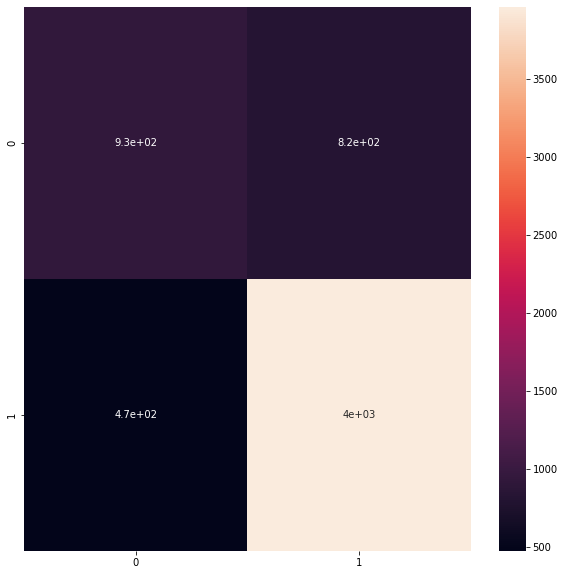

In [194]:
sns.heatmap(cm, annot=True)

In [195]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

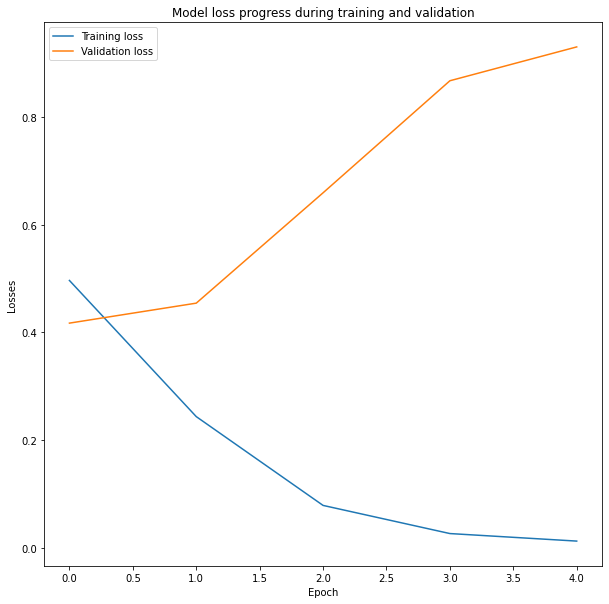

In [196]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Training loss', 'Validation loss'])

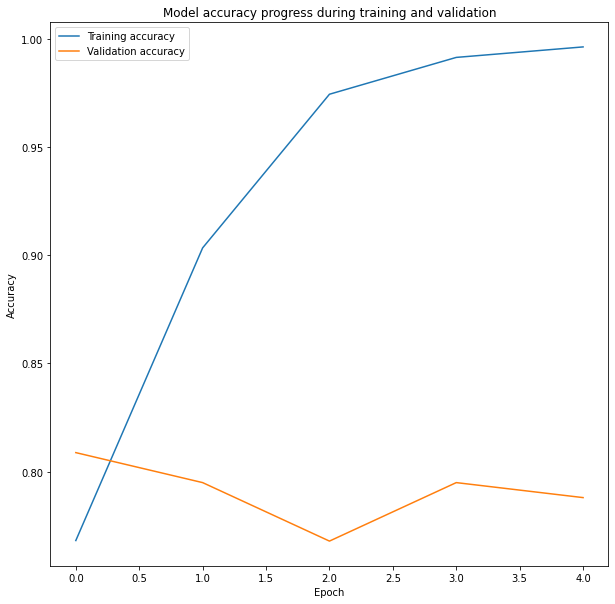

In [197]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])

## Forecasts

In [198]:
text = "I hate"
text = tokenizer.encode(text)
Dcnn(np.array([text]), training=False).numpy()

array([[0.1221664]], dtype=float32)

In [223]:
text = "I happy"
text = tokenizer.encode(text)
Dcnn(np.array([text]), training=False).numpy()

array([[0.9989088]], dtype=float32)

In [230]:
text = "It is complicated"
text = tokenizer.encode(text)
Dcnn(np.array([text]), training=False).numpy()

array([[0.01960316]], dtype=float32)

**Here I created a small function with an algorithm, as the word is placed it will say if it is positive, neutral or negative.**

In [231]:
text = str(input('escreva:   '))
text = tokenizer.encode(text)
text =  Dcnn(np.array([text]), training=False).numpy()
if text >= 0.7:
  print('positivo');
elif text >= 0.4 and text <= 0.69:
    print('neutral')
else:
  print('negativo')

escreva:   It is complicated
negativo


# Conclusion

There is a small difficulty for the algorithm to identify the negative words, as there is a balance between the neutral and positive classes, the algorithm often understands the neutral as positive, as there is no negative word for it to relate to neutrality.
Perhaps if we had a larger database for training the algorithm we could improve it with more vocabulary words, certainly the hit margin will be much better with a broader learning of the database, even so we had a great result with some adjustments to the code.